# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---



En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


### Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 2s 0us/step


In [3]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [4]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
            print("Leyendo {} imágenes encontradas de {}".format(
                len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image, (IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [5]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [7]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

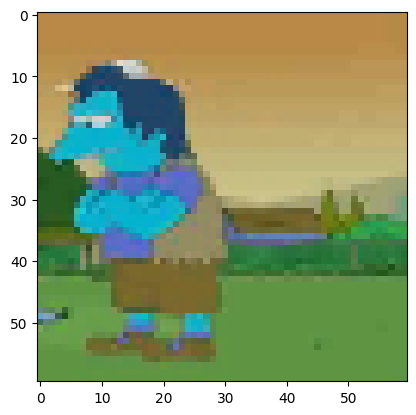

In [8]:
# recordad que siempre es preferible trabajar en blanco y negro
plt.imshow(X_t[2])

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

EJERCICIO GRUPAL - REDES CONVOLUCIONALES
========================================

# 1. Análisis de los datos

Se proporciona información de los datos a utilizar

In [9]:
# número de imágenes training
print(f"Número de imágenes de training: {X.shape[0]}")
# número de imágenes test
print(f"Número de imágenes de test: {X_t.shape[0]}")
# Se obtiene el tamaño de una imagen de entrenamiento
print(f"El tamaño de las imágenes es: {X.shape[1]} x {X.shape[2]}")

Número de imágenes de training: 18992
Número de imágenes de test: 890
El tamaño de las imágenes es: 60 x 60


Se normalizan los valores de los datasets de training y test para que estén entre 0 y 1

In [10]:
X = X / 255.0
X_t = X_t / 255.0

Se crea el dataset de validación en una proporción 80:20 respecto al de training original

In [11]:
# Dividimos el juego de datos de train, en 80% para entrenar el modelo y 20% para validarlo
train_images, val_images, train_labels, val_labels = train_test_split(
    X, y, test_size=0.2, random_state=42)

print(f"Número de imágenes de training: {train_images.shape[0]}")
# número de imágenes validación
print(f"Número de imágenes de validación: {val_images.shape[0]}")

Número de imágenes de training: 15193
Número de imágenes de validación: 3799


Se pasan las etiquetas a variables categóricas

In [12]:
from keras.utils import to_categorical
training_labels = to_categorical(train_labels, num_classes=18)
print(len(training_labels))
validation_labels = to_categorical(val_labels, num_classes=18)
print(len(val_labels))

test_labels = to_categorical(y_t, num_classes=18)

15193
3799


Como resumen sobre los datos que utilizaremos:
- Las imagenes han sido redimensionadas a un tamaño 60x60 píxeles, facilitando su procesamiento.
- Se ha realizado una normalización dividiendo los valores de los píxeles por 255.0 para que se encuentren en un rango entre 0 y 1.
- El conjunto de train consta de 18992 imágenes de personajes, mientras que test tiene 890.
- Se ha utilizado el 80% de las imágenes para entrenar el modelo y el 20% restante para validarlo durante el entrenamiento. Con esta división han quedado 15193 imágenes de train y 3799 de test.

# 2. Modelos

## 2.1 Modelo 1 - 4C (C2D-BN-MAXP), 4N (FD)

### 2.1.1 Composición del modelo

Se plantea el primer modelo de CNN

In [13]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19, InceptionResNetV2
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

img_height = 60
img_width = 60
batch_size = 32
val_split = 0.2
seed = 42
num_classes = 4
learning_rate = 0.001

Añadimos una Callback personalizada que nos va a permitir detener el entrenamiento.

In [14]:
class myCallbackFinal(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.96):
            print(
                "\nAlcanzado el 96% de precisión en datos de test, se cancela el entrenamiento!!")
            self.model.stop_training = True


callbackFinal = myCallbackFinal()

Se construye el primer modelo

In [ ]:
def build_model21():
    model = tf.keras.models.Sequential([
        Conv2D(64, (3, 3), activation='relu',
               padding='same', input_shape=(60, 60, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        # 4 clases: sanas, enfermedad1, enfermedad2, enfermedad3
        Dense(18, activation='softmax')
    ])
    print(model.summary())
    return model

La arquitectura del modelo es la siguiente:

- Cuatro capas convolucionales de 64, 128, 256 y 512 filtros de tamaño 3x3 con función de activación ReLu respectivamente. Se aplica padding para mantener el tamaño de la entrada (60, 60, 3). Todas ellas son seguidas por una capa de Batch Normalization y de MaxPooling para normalizar la activación y reducir la dimnsionalidad. 
- Una capa Flatten para transformar los datos en un vector unidimensional.
- Tres capas Dense de 4096, 2048 y 1024 neuronas respectivamente con función ReLu seguidas de Batch Normalization y un dropout del 50% de neuronas.
- Una capa de salida de 18 neuronas correspondientes a las 18 posibles clases a clasificar con una función de activación softmax.

Se entrena el primer modelo utilizando el optimizador SGD.

In [ ]:
model21 = build_model21()
model21.compile(loss='categorical_crossentropy', optimizer=SGD(
    learning_rate=learning_rate), metrics=['accuracy'])
history21 = model21.fit(train_images, training_labels, epochs=40, batch_size=32, validation_data=(
    val_images, validation_labels), callbacks=[callbackFinal])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                        

### 2.1.2 Análisis de resultados y desempeño

Se evalua el modelo con los datos de test

In [ ]:
test_labels = to_categorical(y_t, num_classes=18)
test_loss, test_accuracy = model21.evaluate(X_t, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

28/28 [==============================] - 0s 15ms/step - loss: 0.1838 - accuracy: 0.9506
Test Loss:  0.18379688262939453
Test Accuracy:  0.9505618214607239


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [ ]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = model21.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

28/28 [==============================] - 0s 5ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.88      0.90        48
  apu_nahasapeemapetilon       0.96      0.98      0.97        50
            bart_simpson       0.91      1.00      0.95        50
charles_montgomery_burns       0.91      1.00      0.95        48
            chief_wiggum       1.00      0.94      0.97        50
          comic_book_guy       1.00      0.92      0.96        49
          edna_krabappel       1.00      0.90      0.95        50
           homer_simpson       0.78      0.98      0.87        50
           kent_brockman       0.98      0.86      0.91        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       0.96      0.86      0.91        50
           marge_simpson       0.98      1.00      0.99        50
     milhouse_van_houten       1.00      0.94      0.97        49

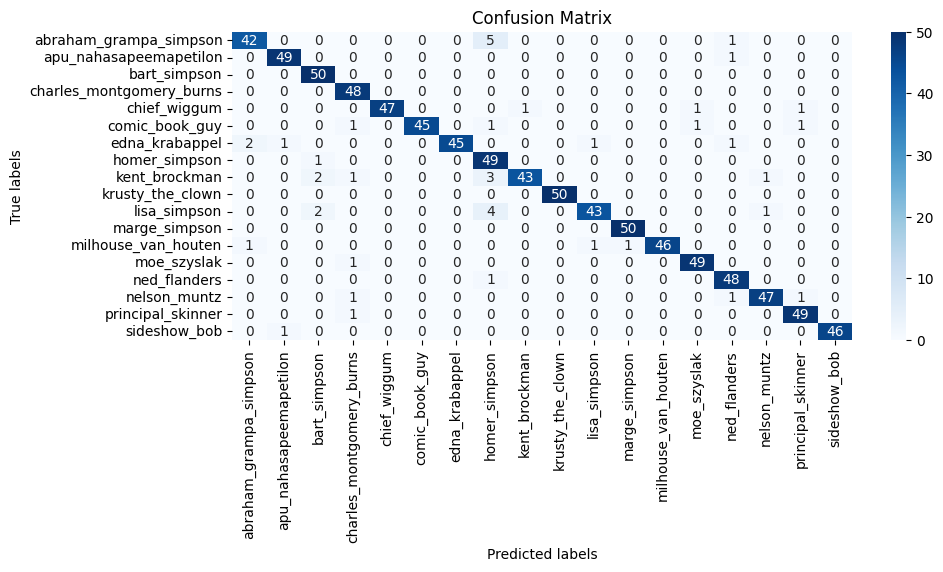

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcula la matriz de confusión
cm = confusion_matrix(y_t, y_pred)

# Crea una figura y un conjunto de ejes
fig, ax = plt.subplots(figsize=(10, 4))

# Crea un mapa de calor a partir de la matriz de confusión
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=True)

# Añade las etiquetas a los ejes
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Añade las etiquetas de las clases a los ejes
# Etiquetas en vertical en el eje X
ax.set_xticklabels(class_names, rotation=90)
# Etiquetas en horizontal en el eje Y
ax.set_yticklabels(class_names, rotation=0)

# Muestra la figura
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


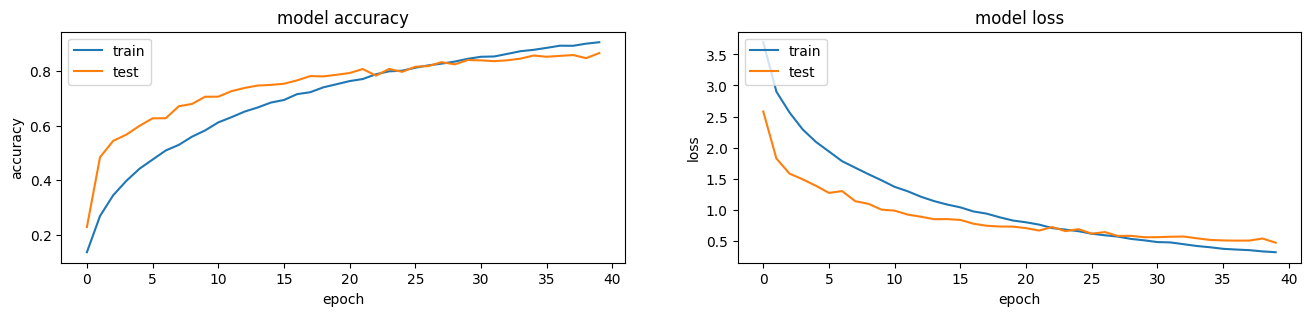

In [ ]:
# list all data in history
thisHistory = history21
print(thisHistory.history.keys())

# summarize history for accuracy
fig = plt.figure(figsize=(16, 3))
f1 = fig.add_subplot(1, 2, 1)
f1.plot(thisHistory.history['accuracy'])
f1.plot(thisHistory.history['val_accuracy'])
f1.set_title('model accuracy')
f1.set_ylabel('accuracy')
f1.set_xlabel('epoch')
f1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
f2 = fig.add_subplot(1, 2, 2)
f2.plot(thisHistory.history['loss'])
f2.plot(thisHistory.history['val_loss'])
f2.set_title('model loss')
f2.set_ylabel('loss')
f2.set_xlabel('epoch')
f2.legend(['train', 'test'], loc='upper left')

fig.show()

Según la evaluación del modelo, los resultados obtenidos son los siguientes:

- Pérdida en el conjunto de prueba: 0.18379688262939453
- Precisión en el conjunto de prueba: 0.9505618214607239
    
Este modelo muestra un buen rendimiento con un accuracy del 95%.

Algunas de las clases que obtienen mejores resultados son "edna_krabappel", "krusty_the_clown", "marge_simpson", "milhouse_van_houten" y "sideshow_bob", con una precisión y recall muy altos. Sin embargo, otras obtienen peores resultados como  "homer_simpson", "abraham_grampa_simpson" y "lisa_simpson". Estas clases muestran una precisión relativamente baja en comparación con otras clases o un recall más bajo en el caso de "lisa_simpson".

## 2.2 Modelo 2 - 4C (C2D - MP) + 2 (F)

### 2.2.1 Composición del modelo

Utilizamos un segundo modelo con un menor número de capas:

In [ ]:
model22 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(60, 60, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The fourth convolution
    # tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    # tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(18, activation='softmax')
])

model22.summary()
model22.compile(loss='categorical_crossentropy', optimizer=SGD(
    learning_rate=learning_rate), metrics=['accuracy'])
history22 = model22.fit(train_images, training_labels, epochs=40, batch_size=32, validation_data=(
    val_images, validation_labels), callbacks=[callbackFinal])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 58, 58, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 128)       

El segundo modelo consta de la siguiente arquitectura:
- Tres capas convolucionales de 32, 64 y 128 respectivamente, con la misma configuración que el modelo anterior. Esta vez solo están seguidas de una capa de MaxPooling para reducir la dimensionalidad. 
- Capa Flatten y dropout del 20%.
- Capa Dense con 512 unidades y función de activación relu.
- Capa de salida : Dense con 18 unidades (correspondiente al número de clases) y función de activación softmax.

Este modelo se ha configurado con la la misma compilación que el primero.

### 2.2.2 Análisis de resultados y desempeño

In [ ]:
test_labels = to_categorical(y_t, num_classes=18)
test_loss, test_accuracy = model22.evaluate(X_t, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

28/28 [==============================] - 0s 8ms/step - loss: 1.4832 - accuracy: 0.5865
Test Loss:  1.4832357168197632
Test Accuracy:  0.5865168571472168


In [ ]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = model22.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

28/28 [==============================] - 0s 2ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.65      0.50      0.56        48
  apu_nahasapeemapetilon       0.79      0.68      0.73        50
            bart_simpson       0.46      0.44      0.45        50
charles_montgomery_burns       0.49      0.54      0.51        48
            chief_wiggum       0.71      0.90      0.80        50
          comic_book_guy       0.88      0.47      0.61        49
          edna_krabappel       0.63      0.34      0.44        50
           homer_simpson       0.47      0.80      0.59        50
           kent_brockman       0.82      0.62      0.70        50
        krusty_the_clown       0.55      0.78      0.64        50
            lisa_simpson       0.45      0.38      0.41        50
           marge_simpson       0.75      0.72      0.73        50
     milhouse_van_houten       0.51      0.61      0.56        49

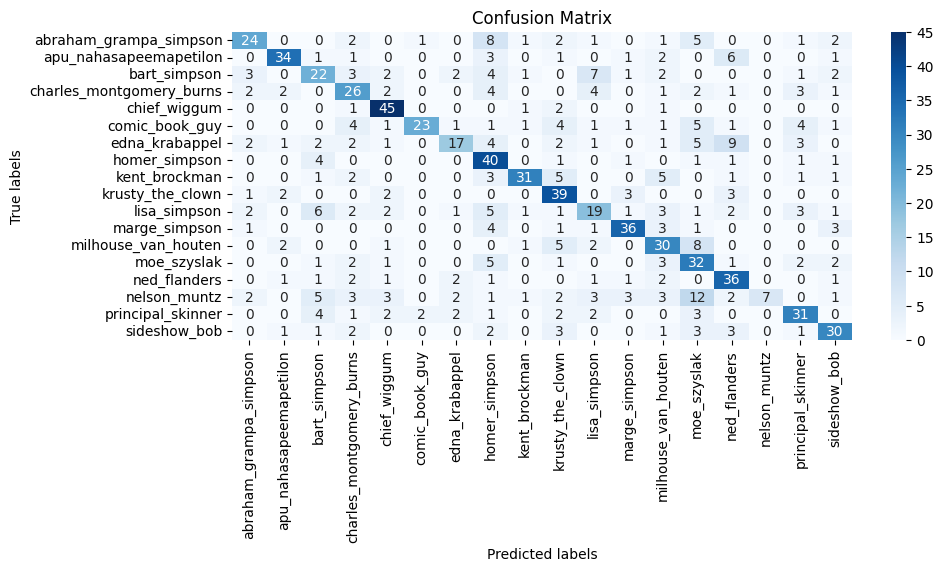

In [ ]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_t, y_pred)

fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=True)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


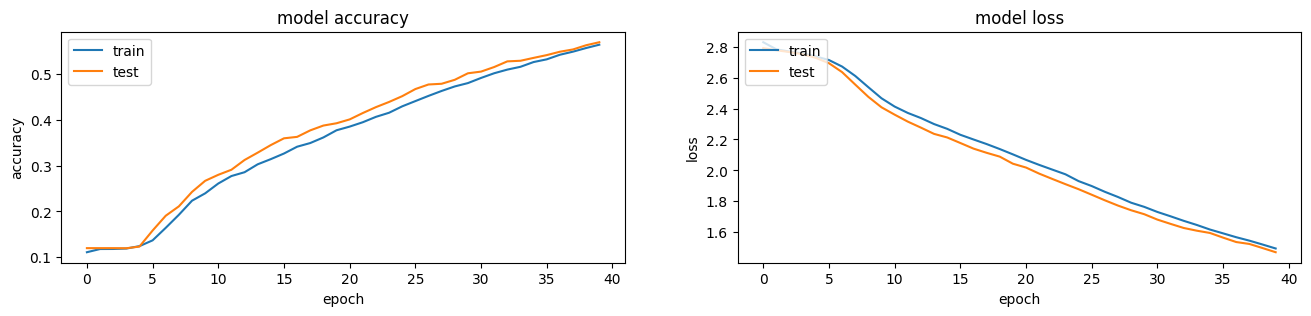

In [ ]:
# list all data in history
thisHistory = history22
print(thisHistory.history.keys())

# summarize history for accuracy
fig = plt.figure(figsize=(16, 3))
f1 = fig.add_subplot(1, 2, 1)
f1.plot(thisHistory.history['accuracy'])
f1.plot(thisHistory.history['val_accuracy'])
f1.set_title('model accuracy')
f1.set_ylabel('accuracy')
f1.set_xlabel('epoch')
f1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
f2 = fig.add_subplot(1, 2, 2)
f2.plot(thisHistory.history['loss'])
f2.plot(thisHistory.history['val_loss'])
f2.set_title('model loss')
f2.set_ylabel('loss')
f2.set_xlabel('epoch')
f2.legend(['train', 'test'], loc='upper left')

fig.show()

Según la evaluación del modelo, los resultados obtenidos son los siguientes:

- Pérdida en el conjunto de prueba: 1.4832357168197632
- Precisión en el conjunto de prueba: 0.5865168571472168
    
Este modelo muestra un peor rendimiento con un acurracy del 59%.
    
Las clases con mejores resultados en términos de precisión y recuperación son "chief_wiggum", "kent_brockman" y "marge_simpson". Por otro lado, las clases con peores resultados son "comic_book_guy", "edna_krabappel" y "nelson_muntz". 

Utilizando un modelo más "simple" se obtienen peores resultados, en este caso por utilizar las cosas menos complejas no se han obtenido mejorías respecto al modelo anterior.

## 2.3 Modelo 3 - Transfer learning VGG19

### 2.3.1 Composición del modelo

Se crea un modelo, en este caso de Transfer Learning usando como base la red pre-etrenada VGG19

In [15]:
def build_modelVGG19():
    # Cargar la red pre-entrenada VGG19
    base_model = VGG19(weights='imagenet', include_top=False,
                       input_shape=(img_height, img_width, 3))

    # Congelar todas las capas de la red base excepto las últimas 12
    for layer in base_model.layers[:-12]:
        layer.trainable = False

    # Añadir capas adicionales para la clasificación
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(18, activation='softmax')(x)

    # Crear el modelo final
    model = Model(inputs=base_model.input, outputs=output)

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

La arquitectura de este último modelo es la siguiente: 
- A partir de la red VGG19 con pesos de 'imagenet' y sin incluir la capa superior (Fully Connected Layers), se congela la mayoría de las capas y añadiendo capas adicionales para adaptar el modelo al problema de clasificación de 18 clases.
- Una capa de Global Average Pooling 2D para reducir la dimensionalidad espacial.
- Dos capas Dense con 1024 y 512 neuronas y función ReLu con un dropout del 50%. 
- Capa de salida Dense igual que los modelos anteriores.

Se compila el modelo utilizando el optimizador Adam con una tasa de aprendizaje de 0.0001, la función de pérdida 'categorical_crossentropy' y la métrica de 'accuracy'.

Se entrena el modelo

In [ ]:
modelvgg19 = build_modelVGG19()
modelvgg19.summary()
history23 = modelvgg19.fit(train_images, training_labels, epochs=20,
                           batch_size=64, validation_data=(val_images, validation_labels))

80134624/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 60, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 60, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 30, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 30, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 30, 30, 128)       147584    
                                                              

### 2.3.2 Análisis de resultados y desempeño

Se evalua con el dataset de test

In [ ]:
test_loss, test_accuracy = modelvgg19.evaluate(X_t, test_labels)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

28/28 [==============================] - 1s 29ms/step - loss: 0.0879 - accuracy: 0.9809
Test Loss:  0.08794691413640976
Test Accuracy:  0.9808988571166992


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [ ]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = modelvgg19.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

28/28 [==============================] - 1s 16ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.94      1.00      0.97        48
  apu_nahasapeemapetilon       0.98      1.00      0.99        50
            bart_simpson       0.96      1.00      0.98        50
charles_montgomery_burns       0.98      1.00      0.99        48
            chief_wiggum       0.96      0.98      0.97        50
          comic_book_guy       1.00      0.96      0.98        49
          edna_krabappel       0.98      0.94      0.96        50
           homer_simpson       1.00      0.98      0.99        50
           kent_brockman       1.00      1.00      1.00        50
        krusty_the_clown       1.00      0.98      0.99        50
            lisa_simpson       1.00      0.92      0.96        50
           marge_simpson       1.00      1.00      1.00        50
     milhouse_van_houten       1.00      0.98      0.99        4

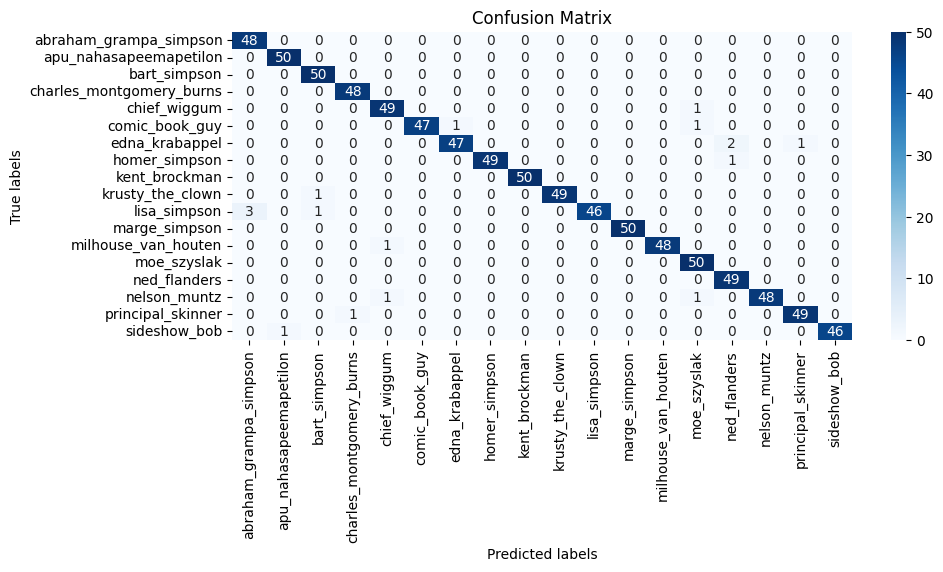

In [ ]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_t, y_pred)

fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=True)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


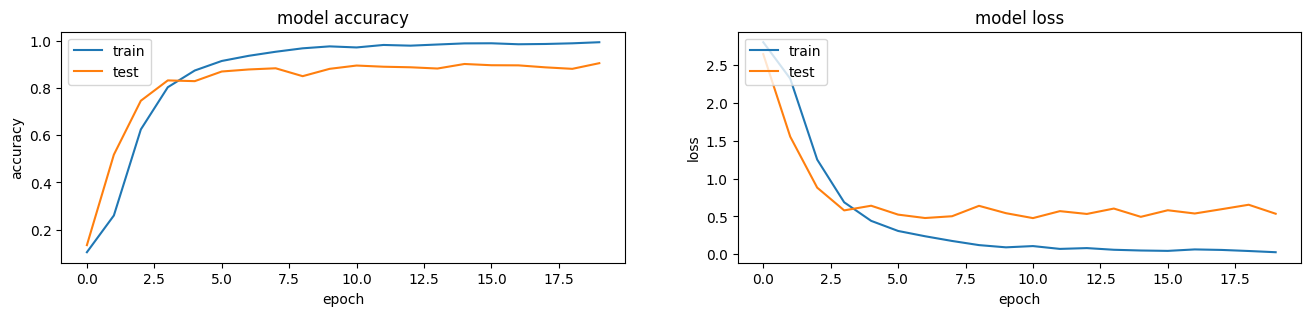

In [ ]:
# list all data in history
thisHistory = history23
print(thisHistory.history.keys())

# summarize history for accuracy
fig = plt.figure(figsize=(16, 3))
f1 = fig.add_subplot(1, 2, 1)
f1.plot(thisHistory.history['accuracy'])
f1.plot(thisHistory.history['val_accuracy'])
f1.set_title('model accuracy')
f1.set_ylabel('accuracy')
f1.set_xlabel('epoch')
f1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
f2 = fig.add_subplot(1, 2, 2)
f2.plot(thisHistory.history['loss'])
f2.plot(thisHistory.history['val_loss'])
f2.set_title('model loss')
f2.set_ylabel('loss')
f2.set_xlabel('epoch')
f2.legend(['train', 'test'], loc='upper left')

fig.show()

La evaluación del modelo muestra que se obtuvo una precisión de 98% y una pérdida de 0.08794691413640976. Este es el modelo que mejores resultados ha generado.

Hay clases con resultados sobresalientes, con un valor de 1 o casi 1 tanto en la precision como el recall. Entre ellas encontramos "kent_brockman", "marge_simpson" y "milhouse_van_houten". Con peores resultados tenemos "abraham_grampa_simpson", con una precisión alta pero recall bajo, o "charles_montgomery_burns" y "comic_book_guy" como las clases con la precision y recall más bajo de todas respectivamente. 

## 2.4. Modelo transfer learning - crecimiento de datos


### 2.4.1 Crecimiento de datos

Ahora vamos con la parte de Data Augmentation

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes_to_keep = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)  # aquí es donde especificas la división

# Generador para el entrenamiento
train_generator = datagen.flow_from_directory(
    '/root/.keras/datasets/simpsons',  # directorio que contiene las imágenes
    target_size=(60, 60),
    batch_size=64,
    class_mode='categorical',
    classes=classes_to_keep,
    shuffle=True,
    subset='training')  # especifica que estas imágenes son para entrenamiento

# Generador para la validación
validation_generator = datagen.flow_from_directory(
    '/root/.keras/datasets/simpsons',  # nota que usamos el mismo directorio que antes
    target_size=(60, 60),
    batch_size=64,
    class_mode='categorical',
    classes=classes_to_keep,
    shuffle=False,
    subset='validation')  # especifica que estas imágenes son para validación

Found 15203 images belonging to 18 classes.
Found 3789 images belonging to 18 classes.


Adicionalmente y para que el Test Generator sea capaz de leer correctamente las imágenes de simpsons_testset, se proporciona este script que crea un directorio por clase y mueve cada imagen a su directorio correspondiente

In [17]:
import os
import shutil

# Directorio donde están todas las imágenes
src_dir = '/root/.keras/datasets/simpsons_testset'

# Obtén la lista de todas las imágenes
image_files = os.listdir(src_dir)

for img in image_files:
    # Ignora los directorios, procesa solo archivos
    if not os.path.isfile(os.path.join(src_dir, img)):
        continue

    # Obtén el nombre de la clase de la imagen (todo lo que precede al último '_')
    class_name = '_'.join(img.split('_')[:-1])

    # Define el nombre del subdirectorio
    class_dir = os.path.join(src_dir, class_name)

    # Si el subdirectorio no existe, crea el subdirectorio
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)

    # Define el nombre de archivo del destino
    dst_file = os.path.join(class_dir, img)

    # Si el archivo de destino no existe, mueve la imagen al subdirectorio
    if not os.path.exists(dst_file):
        shutil.move(os.path.join(src_dir, img), dst_file)

Se cargan las imagenes de test

In [18]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/root/.keras/datasets/simpsons_testset',
    target_size=(60, 60),
    batch_size=64,
    class_mode='categorical',
    classes=classes_to_keep,
    shuffle=False)

Found 890 images belonging to 18 classes.


### 2.4.2 Recomposición del modelo

Se entrena con el primer modelo

In [19]:
model24 = build_modelVGG19()
model24.compile(loss='categorical_crossentropy', optimizer=Adam(
    learning_rate=0.0001), metrics=['accuracy'])
history24 = model24.fit(
    train_generator,
    epochs=20,
    batch_size=64,
    validation_data=validation_generator)  # ajustado para usar todos los datos

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/20
238/238 [==============================] - 128s 449ms/step - loss: 2.8373 - accuracy: 0.1071 - val_loss: 2.7647 - val_accuracy: 0.1301
Epoch 2/20
238/238 [==============================] - 92s 388ms/step - loss: 2.7326 - accuracy: 0.1125 - val_loss: 2.5914 - val_accuracy: 0.1275
Epoch 3/20
238/238 [==============================] - 90s 380ms/step - loss: 2.4384 - accuracy: 0.1946 - val_loss: 2.3126 - val_accuracy: 0.2262
Epoch 4/20
238/238 [==============================] - 91s 381ms/step - loss: 2.0067 - accuracy: 0.3472 - val_loss: 1.9029 - val_accuracy: 0.4204
Epoch 5/20
238/238 [==============================] - 91s 381ms/step - loss: 1.5578 - accuracy: 0.5163 - val_loss: 1.4346 - val_accuracy: 0.5690
Epoch 6/20
238/238 [==============================] - 95s 400ms/step - loss: 1.2422 - accuracy: 0.6243 - val_loss: 1.2653 - val_accuracy: 0.6207
Epoch 7/20
238/238 [==============================] - 89s 376ms/

### 2.4.3 Análisis de resultados y desempeño

Se evalua con los datos de test

In [20]:
test_loss, test_accuracy = model24.evaluate(test_generator)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)

14/14 [==============================] - 2s 152ms/step - loss: 0.2747 - accuracy: 0.9270
Test Loss:  0.2746853232383728
Test Accuracy:  0.9269663095474243


Se crea la matriz de confusión y el classification report para ver como se han comportado cada una de las clases

In [25]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Etiquetas verdaderas
y_true = test_generator.classes

# Se hace la predicción
Y_pred = model24.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=class_names))

#print('Confusion Matrix:')
#print(confusion_matrix(y_true, y_pred))

14/14 [==============================] - 2s 114ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.98      0.83      0.90        48
  apu_nahasapeemapetilon       1.00      0.92      0.96        50
            bart_simpson       0.87      0.96      0.91        50
charles_montgomery_burns       0.92      0.92      0.92        48
            chief_wiggum       1.00      0.92      0.96        50
          comic_book_guy       0.96      0.90      0.93        49
          edna_krabappel       0.96      0.88      0.92        50
           homer_simpson       0.84      0.98      0.91        50
           kent_brockman       1.00      0.90      0.95        50
        krusty_the_clown       0.96      0.98      0.97        50
            lisa_simpson       0.85      0.90      0.87        50
           marge_simpson       0.98      0.92      0.95        50
     milhouse_van_houten       0.96      0.98      0.97        

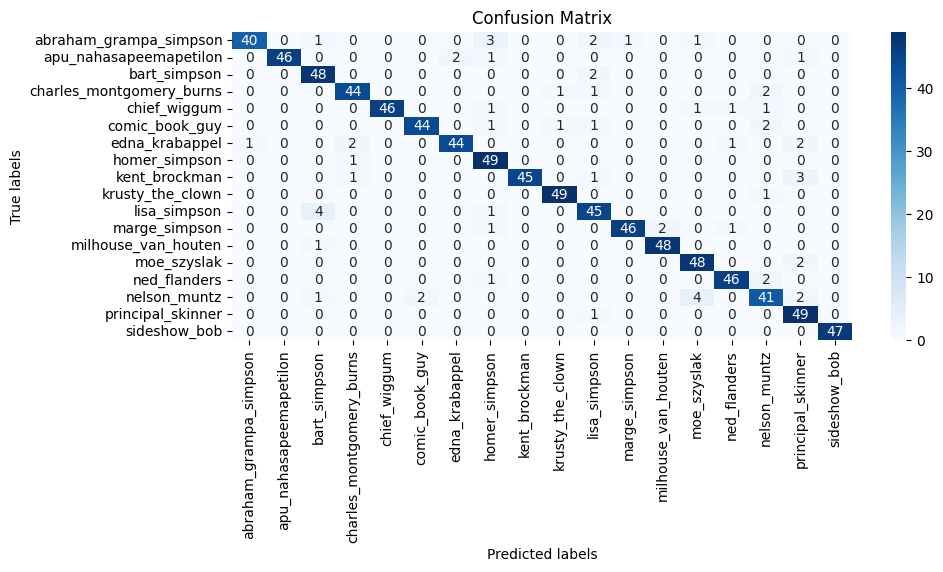

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Calcula la matriz de confusión
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=True)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


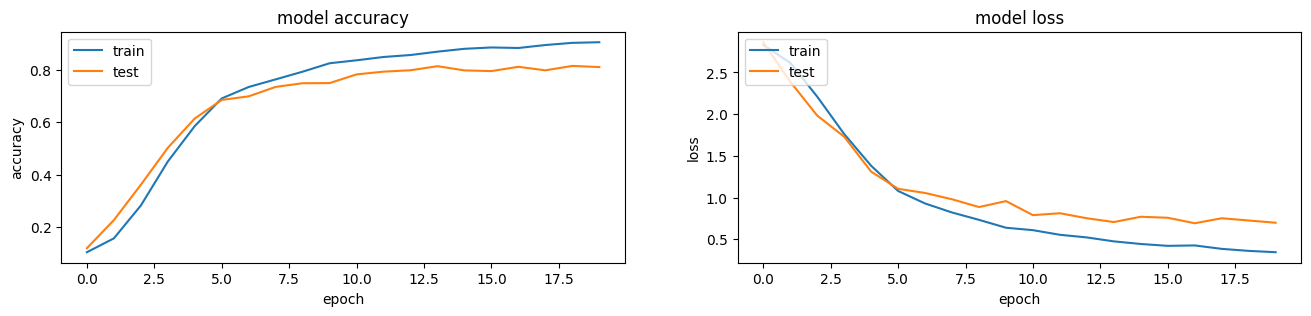

In [ ]:
# list all data in history
thisHistory = history24

print(thisHistory.history.keys())
# summarize history for accuracy

fig = plt.figure(figsize=(16, 3))
f1 = fig.add_subplot(1, 2, 1)
f1.plot(thisHistory.history['accuracy'])
f1.plot(thisHistory.history['val_accuracy'])
f1.set_title('model accuracy')
f1.set_ylabel('accuracy')
f1.set_xlabel('epoch')
f1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
f2 = fig.add_subplot(1, 2, 2)
f2.plot(thisHistory.history['loss'])
f2.plot(thisHistory.history['val_loss'])
f2.set_title('model loss')
f2.set_ylabel('loss')
f2.set_xlabel('epoch')
f2.legend(['train', 'test'], loc='upper left')

fig.show()

Los resultados obtenidos del modelo han sido un 93% de acurracy y:

- Pérdida en el conjunto de prueba: 0.27191972732543945
- Precisión en el conjunto de prueba: 0.9280899167060852

El informe de clasificación muestra que el modelo tiene un rendimiento general muy bueno. Las clases con mayor precisión son "sideshow_bob", "charles_montgomery_burns" y "kent_brockman". En caso contrario tenemos a "moe_szyslak" y "abraham_grampa_simpson" con mal equilibrio entre la precision y el recall.

## 2.5 Modelo 5 - Red neuronal Fully Connected (2F)

### 2.5.1 Composición del modelo

A continuación, crearemos una red neuronal con una arquitectura más simple en comparación con los modelos anteriores, ya que consiste solo en capas densas sin convoluciones ni pooling.

In [ ]:
class myCallbackFinal(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') > 0.89):
            print(
                "\nAlcanzado el 89% de precisión en datos de test, se cancela el entrenamiento!!")
            self.model.stop_training = True


callbackFinal = myCallbackFinal()

model_fully_connected = keras.Sequential([
    keras.layers.Flatten(input_shape=(60, 60, 3)),
    keras.layers.Dense(150, activation='elu'),
    keras.layers.Dense(18, activation='softmax')
])

model_fully_connected.compile(optimizer=Adam(learning_rate=0.0001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

history_final = model_fully_connected.fit(train_images, training_labels, epochs=40, batch_size=64, validation_data=(
    val_images, validation_labels), callbacks=[callbackFinal])

Epoch 1/40
238/238 [==============================] - 3s 8ms/step - loss: 2.4040 - accuracy: 0.2692 - val_loss: 2.2315 - val_accuracy: 0.3398
Epoch 2/40
238/238 [==============================] - 1s 5ms/step - loss: 2.0701 - accuracy: 0.3812 - val_loss: 2.0089 - val_accuracy: 0.4035
Epoch 3/40
238/238 [==============================] - 1s 5ms/step - loss: 1.9377 - accuracy: 0.4176 - val_loss: 1.9722 - val_accuracy: 0.4241
Epoch 4/40
238/238 [==============================] - 1s 5ms/step - loss: 1.8212 - accuracy: 0.4593 - val_loss: 1.9608 - val_accuracy: 0.4198
Epoch 5/40
238/238 [==============================] - 1s 5ms/step - loss: 1.7538 - accuracy: 0.4789 - val_loss: 1.8561 - val_accuracy: 0.4567
Epoch 6/40
238/238 [==============================] - 1s 5ms/step - loss: 1.6852 - accuracy: 0.4990 - val_loss: 1.9107 - val_accuracy: 0.4396
Epoch 7/40
238/238 [==============================] - 1s 5ms/step - loss: 1.6249 - accuracy: 0.5175 - val_loss: 1.8297 - val_accuracy: 0.4604
Epoch 

La arquitectura del modelo es la siguiente:

- Capa de entrada: Flatten que transforma la imagen en un vector unidimensional.
- Capa densa: Con 150 unidades y función de activación 'elu'.
- Capa de salida: Dense con 18 unidades y función de activación softmax.

El modelo utiliza el optimizador Adam. También se utiliza el callback myCallbackFinal para verificar si la precisión en los datos de validación alcanza el 89% y así detener el entrenamiento. 

### 2.5.2 Análisis de resultados y desempeño

In [ ]:
test_loss, test_accuracy = model_fully_connected.evaluate(
    X_t, test_labels, verbose=2)
print('Precisión del modelo:', test_accuracy)

28/28 - 0s - loss: 0.8432 - accuracy: 0.7697 - 121ms/epoch - 4ms/step
Precisión del modelo: 0.7696629166603088


In [ ]:
class_names = [MAP_CHARACTERS[i] for i in range(len(MAP_CHARACTERS))]

# Matriz de confusión y métricas adicionales
Y_pred = model_fully_connected.predict(X_t)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report:')
print(classification_report(y_t, y_pred, target_names=class_names))

# print('Confusion Matrix:')
# print(confusion_matrix(y_t, y_pred))

28/28 [==============================] - 0s 3ms/step
Classification Report:
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.85      0.58      0.69        48
  apu_nahasapeemapetilon       0.87      0.92      0.89        50
            bart_simpson       0.67      0.80      0.73        50
charles_montgomery_burns       0.88      0.77      0.82        48
            chief_wiggum       0.93      0.84      0.88        50
          comic_book_guy       1.00      0.61      0.76        49
          edna_krabappel       1.00      0.56      0.72        50
           homer_simpson       0.58      0.90      0.70        50
           kent_brockman       0.93      0.76      0.84        50
        krusty_the_clown       0.91      0.78      0.84        50
            lisa_simpson       0.90      0.52      0.66        50
           marge_simpson       0.86      0.84      0.85        50
     milhouse_van_houten       0.86      0.78      0.82        49

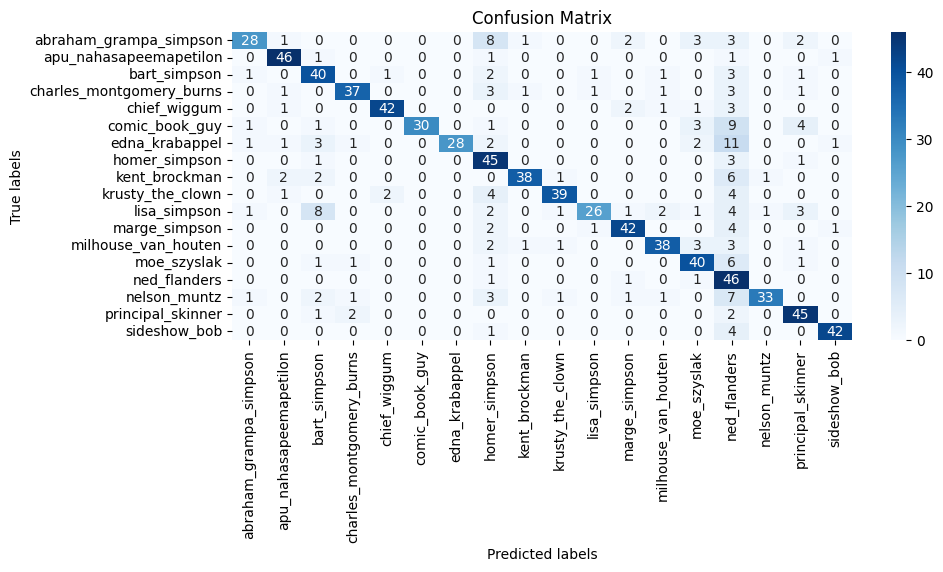

In [ ]:
# Calcula la matriz de confusión
cm = confusion_matrix(y_t, y_pred)

fig, ax = plt.subplots(figsize=(10, 4))

sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=True)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.set_xticklabels(class_names, rotation=90)
ax.set_yticklabels(class_names, rotation=0)

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


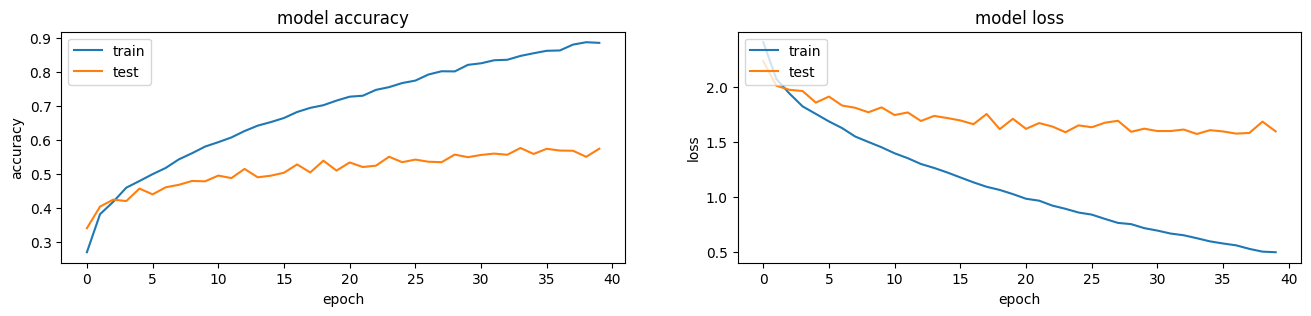

In [ ]:
# list all data in history
thisHistory = history_final
print(thisHistory.history.keys())

# summarize history for accuracy
fig = plt.figure(figsize=(16, 3))
f1 = fig.add_subplot(1, 2, 1)
f1.plot(thisHistory.history['accuracy'])
f1.plot(thisHistory.history['val_accuracy'])
f1.set_title('model accuracy')
f1.set_ylabel('accuracy')
f1.set_xlabel('epoch')
f1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
f2 = fig.add_subplot(1, 2, 2)
f2.plot(thisHistory.history['loss'])
f2.plot(thisHistory.history['val_loss'])
f2.set_title('model loss')
f2.set_ylabel('loss')
f2.set_xlabel('epoch')
f2.legend(['train', 'test'], loc='upper left')

fig.show()

Los resultados muestran que el modelo fully connected obtuvo una precisión del 0.7697 en los datos de prueba y una pérdida de 0.8432, por tanto a pesar de ser capaz de clasificar correctamente alrededor del 77%, su rendimiento es inferior en comparación con los modelos CNN 1 y 3.

Esto se puede deber a que los modelos anteriores utilizan capas convolucionales capaces de extraer características o generalizar los datos de las imágenes. Estas capas son útiles en tareas de clasificación de imágenes gracias a que pueden detectar patrones locales y aprender representaciones más significativas. El modelo fully connected trata las imágenes como un vector unidimensional, lo que limita su capacidad para capturar características relevantes. Además, también tiene más parámetros en comparación con los modelos CNN anteriores, lo que puede llevar a un mayor riesgo de sobreajuste.

# 3. Comparación de modelos

## 3.1. Comparación de modelos CNN

**MODELO 1:**
- Arquitectura: Arquitectura CNN con varias capas convolucionales, capas de agrupación y capas completamente conectadas.
- Profundidad: Tiene una arquitectura más profunda que el MODELO 2 y el MODELO 3, con múltiples capas convolucionales y capas completamente conectadas.
- Hiperparámetros: Utiliza varios hiperparámetros como el tamaño del kernel, la activación, el relleno, el tamaño de la agrupación y la tasa de dropout para ajustar su rendimiento.
- Técnicas de regularización: Utiliza las capas de dropout al 50% y la batch normalization para reducir el sobreajuste y mejorar la generalización del modelo.
- Optimizador: Utiliza el optimizador SGD con una tasa de aprendizaje definida para el entrenamiento del modelo.
- Resultados: Alta precision y recall, con un acurracy del 95%.

**MODELO 2:**
- Arquitectura: Arquitectura más simple con menos capas convolucionales y sin capas completamente conectadas intermedias.
- Profundidad: Tiene una arquitectura menos profunda en comparación con el anterior.
- Hiperparámetros: Utiliza hiperparámetros similares al MODELO 1 pero con menos capas y menos parámetros en total.
- Técnicas de regularización: Utiliza una capa de dropout 20% para regularizar el modelo y evitar el sobreajuste.
- Optimizador: Mismo que el anterior.
- Resultados: Sus resultados son los peores en comparación con los otros dos modelos, con una precisión media del 59%.

**MODELO 3:**
- Arquitectura: Utiliza la arquitectura VGG19 como base, congelando la mayoría de las capas y agregando capas adicionales para la clasificación.
- Profundidad: El MODELO 3 es menos profundo que el MODELO 1 en términos de capas pero aprovecha el conocimiento de la red VGG19 preentrenada.
- Hiperparámetros: Similares al MODELO 1 y MODELO 2 para las capas adicionales agregadas, como el tamaño de la capa oculta y la tasa de dropout.
- Técnicas de regularización: Dos dropuot al 50%.
- Optimizador: Utiliza el optimizador Adam con una tasa de aprendizaje de 0.0001 para el entrenamiento del modelo.
- Resultados: Los resultados son los mejores, llegando al 98% de acurracy.

En conclusión, el MODELO 3 parece ser el más efectivo en términos de rendimiento, con una pérdida de prueba muy baja (0.0879) y una alta precisión (0.9809). El MODELO 1 también muestra buenos resultados con 0.1838 y 0.9506 como resultado de la perdida y precisión, mientras que el MODELO 2 muestra un rendimiento muy inferior en comparación con los otros dos, con una tasa de pérdida más alta (1.4832) y una precisión más baja (0.5865).

**ANÁLISIS DE CLASES:**

Los personajes que mejores resultados han dado en común en los tres modelos son "apu_nahasapeemapetilon", "marge_simpson" y "milhouse_van_houten", que se encuentran con los valores más altos en comparación con las demás clases clasificadas. 
Los personajes que tienden a tener resultados más bajos son "bart_simpson", "comic_book_guy" y "nelson_muntz".

## 3.2. Comparación resultados obtenidos

La tabla resumen muestra los resultados obtenidos de cinco modelos diferentes, evaluados en términos de la precisión promedio ponderada (W.A. Prec.), el recall promedio ponderado (W.A. Rec.) y el puntaje F2 promedio ponderado (W.A. F2)


| Modelos                       | W.A. Prec. | W.A. Rec. | W.A. F2 |
|-------------------------------|------------|-----------|---------|
| CNN 4C (C2D-BN-MAXP), 4N (FD) | 0.95       | 0.95      | 0.95    |
| CNN 4C (C2D - MP) + 2 (F)     | 0.63       | 0.59      | 0.58    |
| T.L. VGCC19                   | 0.98       | 0.98      | 0.98    |
| T.L. VGCC19 Aug.Data          | 0.93       | 0.93      | 0.93    |
| RNN (2F)                      | 0.83       | 0.77      | 0.78    |


"T.L. VGCC19" y "CNN 4C (C2D-BN-MAXP), 4N (FD)" destacan como los mejores modelos en términos de precisión, recall y puntaje F2. El modelo "CNN 4C (C2D - MP) + 2 (F)" muestra un rendimiento medio bajo, lo que significa dificultades para clasificar correctamente algunas de las clases.

El modelo "T.L. VGCC19 Aug.Data" muestra un rendimiento ligeramente inferior al modelo "T.L. VGCC19" en todos los aspectos evaluados. Esto sugiere que el aumento de datos utilizado en el modelo no proporcionó una mejora significativa en la precisión y el recall de las clases.

# 4. Conclusiones finales

Durante la realización de esta actividad se han modificado los hiperparametros de los modelos para evaluar el impacto de las distintas capas neuronales:
- Se ha testado con 4 capas con drop out y 4 capas fully connected y se ha obtenido un resultado más favorable con mayor número de capas y drop out.
- Como optimizador finalmente nos hemos inclinado por Adam frente a SGD. Dado que el optimizador estocástico de desciente del gradiente no da un resultado comparable al ADAM.
- El tamaño del batch se ha enfrentado 64 y 32.

Por otro lado, el mejor resultado se ha obtenido con los modelos de transfer learning. En el primer modelo testado, realizado sin crecimiento de datos se han logrado valores de accuracy notablemente elevados del 98%, idem para el recall y el f2. Al realizar el crecimiento de datos se ha bajo sustancialmente este nivel de acierto.

Se ha observado que la red neuronal testada, comparable al segundo modelo convolucional evaluado, tiene mejor desempeño que dicho segundo modelo convolucional de 512 neuronas frente a las 150 del modelo de red neuronal en la capa intermedia.